In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy as sp
import time

In [2]:
#opens .dat files to be converted into CSVs
#change pathprefix on different computers
EOS_files = "/home/tplohr/proj/SF 24-25/diettim NMMA master EOS-chiralEFT_MTOV/"
NICER_data = "/home/tplohr/proj/SF 24-25/data/J0030_Amsterdam_2019.dat"

def loadfile(number):
    file = open(EOS_files + str(number) + '.dat', 'r')
    return file

In [3]:
#creates an empty array to contain all EOSs 
numofEOS = 5000
EOSs = [None] * numofEOS

#fills "EOSs" with arrays of each EOS's mass and radius values 
for i in range(numofEOS):
    df = pd.read_csv(loadfile(i+1), delimiter = '\t', names = ["radius", "mass", "deformability"])
    EOSs[i] = np.array([df["radius"], df["mass"]])
#EOSs[i] is EOS_i
#EOSs[i][0] is the list of radius values of EOS_i
#EOSs[i][1] is the list of mass values of EOS_i
#EOSs[i][0][j] is the radius value indexed j of EOS_i
#EOSs[i][1][j] is the mass value indexed j of EOS_i

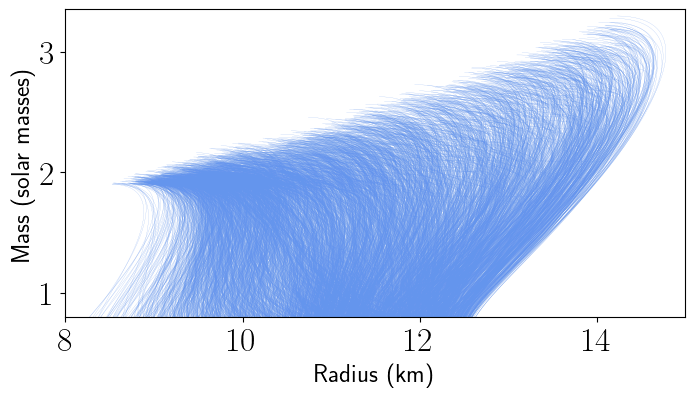

In [4]:
#plots each EOS 
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.plot(EOSs[i][0], EOSs[i][1], 'cornflowerblue', linewidth=.1)

In [5]:
#initialization of probability arrays

#probabilities of the EOSs given the observations, each index corresponds to one EOS; posterior
P_EOS_given_obs = np.zeros(numofEOS)
#probabilities of the observations given an EOS; likelihood
P_obs_given_EOS = np.zeros(numofEOS)
#probabilities of the EOSs without a condition; prior
P_EOS = np.ones(numofEOS)/numofEOS
#list of radius values each EOS predicts at M=1.4
r_at_given_mass = np.zeros(numofEOS)

In [6]:
mu_1 = 2.14
mu_2 = 2.01
mu_3 = 1.908
mu_4 = 2.16
sigma_1 = 0.1
sigma_2 = 0.04
sigma_3 = 0.016
sigma_4 = 0.17
#pdf of all CDFs combined
def pdf_1_evaluate(max_m):
    return sp.stats.norm.cdf(max_m, mu_1, sigma_1) * sp.stats.norm.cdf(max_m, mu_2, sigma_2) * sp.stats.norm.cdf(max_m, mu_3, sigma_3) * (1-sp.stats.norm.cdf(max_m, mu_4, sigma_4))

In [7]:
#reading in the data from NICER
dataframe = pd.read_csv(NICER_data, delim_whitespace=True, header=None)
selected_columns = dataframe.iloc[:,[1,2]]
data = selected_columns.to_numpy()[:10000]
print(np.shape(data))
#using a KDE to get the probability density function for the likelihood
pdf_2 = sp.stats.gaussian_kde((data[:,1], data[:,0]))
print(data[:,1])
print(data[:,0])

(10000, 2)
[11.66190213 12.92628253 12.9648249  ... 12.50780779 12.73977794
 12.33236365]
[1.2962671  1.09584669 1.29454128 ... 1.29311117 1.3139701  1.37314422]


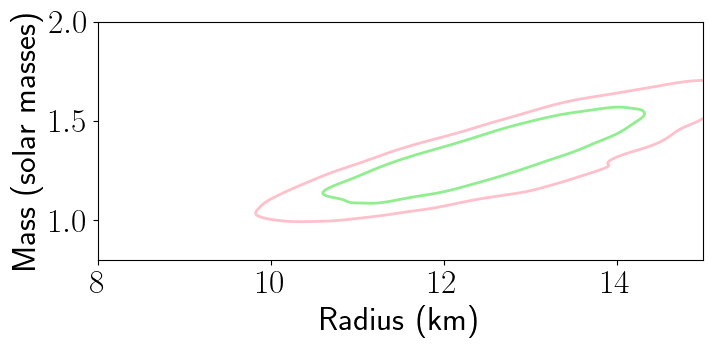

In [8]:
# Create the X and Y grids
X = np.linspace(8, 15, 250)
Y = np.linspace(0.8, 2.0, 250)

# Create meshgrid for X and Y
X_grid, Y_grid = np.meshgrid(X, Y)

# Points array with 250 * 250 points
points = np.zeros((250 * 250, 3))

# Probability array to store probability values
prob = np.zeros((250, 250))

# Loop to evaluate and populate points and prob 
for i in range(250):
    for j in range(250):
        Z = pdf_2.evaluate((X[i], Y[j]))[0]  # Evaluate the PDF
        points[i + j * 250, :] = [X[i], Y[j], Z]  # Store the values in points array
        prob[i, j] = Z  # Store Z value in prob array

# Normalize the probabilities
norm = plt.Normalize(points[:, 2].min(), points[:, 2].max())
cmap = mp.colors.LinearSegmentedColormap.from_list("blue_white_red", ["blue", "white", "red"])

# Plotting the scatter plot
plt.xlabel("Radius (km)")
plt.ylabel("Mass (solar masses)")
#plt.scatter(points[:, 0], points[:, 1], color=cmap(norm(points[:, 2])), s=3)
plt.tight_layout()
#plt.show()

# Normalize prob and calculate the integral
norm_prob = prob / prob.sum()
n = 100
t = np.linspace(0, norm_prob.max(), n)
integral = ((norm_prob >= t[:, None, None]) * norm_prob).sum(axis=(1, 2))

# Interpolate the integral to find corresponding t values
from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([0.95, 0.68]))

# Contour plot using meshgrid for X and Y
plt.contour(X_grid, Y_grid, norm_prob.T, t_contours, colors=["pink", "lightgreen"])
plt.show()

In [9]:
print(t_contours)

[1.67431885e-05 7.78318295e-05]


In [10]:
#calculate the probability of the observations given an EOS; likelihood
num_points = 1000
def calc_P_obs_given_EOS(i):
    #r is the interpolated function r(m)
    r = sp.interpolate.interp1d(EOSs[i][1], EOSs[i][0])
    #radius at mass 1.4 
    r_at_given_mass[i] = r(1.4)
    
    #various radius values
    min_m = np.min(EOSs[i][1])
    max_m = np.max(EOSs[i][1])

    def integrand(m):
        return pdf_2((r(m), m))
    P_NICER = sp.integrate.quad(integrand, min_m, max_m)[0]
    #then multiply by the probability using the max mass constraints
    P = P_NICER * pdf_1_evaluate(max_m)
    return P

In [ ]:
start=time.time()
norm_factor = 0
for i in range(numofEOS):
    #calculate the likelihood
    P_obs_given_EOS[i] = calc_P_obs_given_EOS(i)
    #calculate the denominator (sum of the numerator)
    norm_factor += P_obs_given_EOS[i]

#calculate the posterior
P_EOS_given_obs = P_obs_given_EOS / norm_factor
end=time.time()
print((end-start),'s', (end-start)/60, "m")

/tmp/ipykernel_22164/243174392.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_NICER = sp.integrate.quad(integrand, min_m, max_m)[0]
/tmp/ipykernel_22164/243174392.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  P_NICER = sp.integrate.quad(integrand, min_m, max_m)[0]


In [ ]:
plt.xlabel("EOS number", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.scatter(np.linspace(0,numofEOS,5000), P_EOS_given_obs, s=0.4)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/step_c/step_c_scatter_plot_integrate.png")

In [ ]:
tot_prob = 0
for i in range(numofEOS):
    tot_prob += P_EOS_given_obs[i]
print(tot_prob)

In [ ]:
#plotting each EOS; low probability is white, high probability is red
cmap = mp.colors.LinearSegmentedColormap.from_list("white_to_red", ["white","red"])
norm = plt.Normalize(P_EOS_given_obs.min(), P_EOS_given_obs.max())
#plots each EOS 
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    color = cmap(norm(P_EOS_given_obs[i]))
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.plot(EOSs[i][0], EOSs[i][1], color=color, linewidth=.1)
plt.tight_layout()
plt.contour(X_grid, Y_grid, norm_prob.T, t_contours, colors=["pink", "lightgreen"])
plt.savefig("/home/tplohr/proj/SF 24-25/figs/step_c/step_c_EOS_prob_plot_integrate.png")

In [ ]:
r_pdf = sp.stats.gaussian_kde((r_at_given_mass), weights=P_EOS_given_obs, bw_method = 0.05)
#plotting the radius pdf
Y = np.linspace(8, 15, 5000)
prob2=np.zeros(5000)
for i in range(5000):
    prob2[i] = r_pdf.evaluate(Y[i])

cdf = np.cumsum(prob2) * (Y[1] - Y[0])
indices = [np.searchsorted(cdf, 0.05), np.searchsorted(cdf, 0.95)]
percentiles = [Y[indices[0]], Y[indices[1]]]
print(percentiles)
plt.xlabel("Radius (km)")
plt.ylabel("Probability")
plt.axvline(x=percentiles[0], color='cornflowerblue', linestyle='dotted', label="5th Percentile")
plt.axvline(x=percentiles[1], color='cornflowerblue', linestyle='dotted', label="95th Percentile")
plt.plot(Y, prob2)
plt.tight_layout()

In [ ]:
r_pdf = sp.stats.gaussian_kde((r_at_given_mass), weights=P_EOS_given_obs, bw_method = 0.1)
#plotting the radius pdf
Y = np.linspace(8, 15, 5000)
prob2=np.zeros(5000)
for i in range(5000):
    prob2[i] = r_pdf.evaluate(Y[i])

cdf = np.cumsum(prob2) * (Y[1] - Y[0])
indices = [np.searchsorted(cdf, 0.05), np.searchsorted(cdf, 0.95)]
percentiles = [Y[indices[0]], Y[indices[1]]]
print(percentiles)
plt.xlabel("Radius (km)")
plt.ylabel("Probability")
plt.axvline(x=percentiles[0], color='cornflowerblue', linestyle='dotted', label="5th Percentile")
plt.axvline(x=percentiles[1], color='cornflowerblue', linestyle='dotted', label="95th Percentile")
plt.plot(Y, prob2)
plt.tight_layout()

In [ ]:
r_pdf = sp.stats.gaussian_kde((r_at_given_mass), weights=P_EOS_given_obs, bw_method = 0.15)
#plotting the radius pdf
Y = np.linspace(8, 15, 5000)
prob2=np.zeros(5000)
for i in range(5000):
    prob2[i] = r_pdf.evaluate(Y[i])

cdf = np.cumsum(prob2) * (Y[1] - Y[0])
indices = [np.searchsorted(cdf, 0.05), np.searchsorted(cdf, 0.95)]
percentiles = [Y[indices[0]], Y[indices[1]]]
print(percentiles)
plt.xlabel("Radius (km)")
plt.ylabel("Probability")
plt.axvline(x=percentiles[0], color='cornflowerblue', linestyle='dotted', label="5th Percentile")
plt.axvline(x=percentiles[1], color='cornflowerblue', linestyle='dotted', label="95th Percentile")
plt.plot(Y, prob2)
plt.tight_layout()

In [ ]:
r_pdf = sp.stats.gaussian_kde((r_at_given_mass), weights=P_EOS_given_obs, bw_method = 0.20)
#plotting the radius pdf
Y = np.linspace(8, 15, 5000)
prob2=np.zeros(5000)
for i in range(5000):
    prob2[i] = r_pdf.evaluate(Y[i])

cdf = np.cumsum(prob2) * (Y[1] - Y[0])
indices = [np.searchsorted(cdf, 0.05), np.searchsorted(cdf, 0.95)]
percentiles = [Y[indices[0]], Y[indices[1]]]
print(percentiles)
plt.xlabel("Radius (km)")
plt.ylabel("Probability")
plt.axvline(x=percentiles[0], color='cornflowerblue', linestyle='dotted', label="5th Percentile")
plt.axvline(x=percentiles[1], color='cornflowerblue', linestyle='dotted', label="95th Percentile")
plt.plot(Y, prob2)
plt.tight_layout()